In [55]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import numpy as np
import scipy as sp
import joblib
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ROOT as root
from pylab import *

import iminuit
from iminuit import Minuit, cost

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

In [54]:
# modules in this directory
import visualization, util, event, cutflow, detector, Kalman_tom
import visualization as vis
import cutflow,detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(Kalman_tom)

<module 'Kalman_tom' from '/project/6035200/tomren/jupyter/tracker_analysis/Kalman_tom.py'>

# Fit methods comparison

1. LS fit, with (x0,t0,z0,vx,vy,vz) as parameters
2. Kalman filter, with (vx,vy,vz) as parameters, Q=0
3. Kalman filter, with (x0,t0,z0,vx,vy,vz) as parameters, Q=0
4. Kalman filter, with (vx,vy,vz) as parameters, Q from multiple scattering (**Current MATHUSLA implementation**)
5. Kalman filter, with (x0,t0,z0,vx,vy,vz) as parameters, Q from multiple scattering

1 and 4 should be equal mathmatically

In [144]:
Tree=ev.Tree
barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0', 'Track_k_m_y0', 'Track_k_m_z0', 'Track_k_m_t0', 'Track_k_m_Erro

In [147]:
# Data preparation:
# get all tracks that have 7 hits (one hit per layer)
cut=cutflow.sample_space("")

def get_digi_hits(ev):
    ev.Tree.GetEntry(ev.EventNumber)
    hits=[]
    for ii in range(len(ev.Tree.Digi_y)):
        hit=Hit(ev.Tree.Digi_x[ii], ev.Tree.Digi_y[ii], ev.Tree.Digi_z[ii], ev.Tree.Digi_time[ii])
        hit.get_uncertainty()
        hits.append(hit)
    return hits

def get_event_truth(ev):
    ev.Tree.GetEntry(ev.EventNumber)
    dx=ev.Tree.Hit_x[1]-ev.Tree.Hit_x[0]
    dy=ev.Tree.Hit_y[1]-ev.Tree.Hit_y[0]
    dz=ev.Tree.Hit_z[1]-ev.Tree.Hit_z[0]
    dt=ev.Tree.Hit_time[1]-ev.Tree.Hit_time[0]
    truth=[ev.Tree.Hit_x[0], ev.Tree.Hit_y[0], ev.Tree.Hit_z[0], ev.Tree.Hit_time[0],dx/dt, dy/dt, dz/dt]
    return truth

class Hit:
    def __init__(self, x, y, z, t):
        self.x=x
        self.y=y
        self.z=z
        self.t=t
        self.t_uncertainty=1
    def get_uncertainty(self):
        # Get the layer-dependent uncertainty of each hit
        self.hit_layer=cut.in_layer(self.y)
        hit_uncertainty = np.array(detector.Layer().uncertainty(self.hit_layer))
        self.x_uncertainty=hit_uncertainty[0]*100 # m->cm
        self.z_uncertainty=hit_uncertainty[2]*100 # m->cm
        self.y_uncertainty=2/np.sqrt(12)

def gen_hits(Vx=2,Vy=29,Vz=3,x0=450,z0=450+11950):
    Y_LAYERS = np.array([0,1, 5,6,7,8,9])*100 #cm
    unc_low = 0.04/np.sqrt(12)*100 #cm
    unc_high = 1*sp.constants.c/1e7/np.sqrt(2)/1.5 #cm
    UNC_X = [unc_low,unc_high,unc_low,unc_high,unc_low,unc_high,unc_low]
    UNC_Z = [unc_high,unc_low,unc_high,unc_low,unc_high,unc_low,unc_high]
    UNC_T = 1 #ns
    UNC_Y = 2/np.sqrt(12) #uncertainty in thickness, cm

    hits=[]
    hits_truth=[]
    hits_err=[]
    for i in range(len(Y_LAYERS)):
        t=(Y_LAYERS[i]-Y_LAYERS[0])/Vy
        hits_truth.append([x0+Vx*t,Y_LAYERS[i], z0+Vz*t, t])
        hits.append(Hit(x0+Vx*t+np.random.normal(0,UNC_X[i]),
                     Y_LAYERS[i],
                     z0+Vz*t+np.random.normal(0,UNC_Z[i]),
                     t+np.random.normal(0,UNC_T)))
        hits[-1].x_uncertainty=UNC_X[i]
        hits[-1].z_uncertainty=UNC_Z[i]
        hits[-1].y_uncertainty=UNC_Y
        hits_err.append([UNC_X[i],0.005,UNC_Z[i],UNC_T])
        
    return np.array(hits),np.array(hits_err),np.array(hits_truth)

# N_events=10
# Hit_collection={}
# for i in range(N_events):
#     Hit_collection[i],_,hits_truth=gen_hits()

In [148]:
muon_energy=100
print("Processing energy ",muon_energy, "GeV")

data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV/*/*/stat*.root",)
files=util.Utils.sortByExt(files)

Hit_collection = []
Truth_collection = []
for i_file in tqdm(range(len(files))):
# for i_file in tqdm(range(10)):
    filename=files[i_file]
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    nevents = int(ev.Tree.GetEntries())

    for i_event in range(nevents):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)
        if len(ev.Tree.Digi_x)==7:
            hits = get_digi_hits(ev)
            truth =  get_event_truth(ev)
            
            Hit_collection.append(hits)
            Truth_collection.append(truth)
            
joblib.dump([Hit_collection,Truth_collection],"hits_100GeV.joblib")

Processing energy  100 GeV


100%|██████████| 200/200 [00:14<00:00, 13.95it/s]


['hits_100GeV.joblib']

## 1. Define LS fit

In [78]:
# -------------------------------------
# LS fit
# ------------------------------------
class chi2_track:
    def __init__(self, hits):
        self.hits=hits
        self.func_code = iminuit.util.make_func_code(['x0', 'y0', 'z0', 't0', 'vx', 'vy', 'vz'])
    def __call__(self, x0, y0, z0, t0, vx, vy, vz):
        error=0
        for hit in self.hits:
            model_t = (hit.y - y0)/vy
            model_x = x0 + model_t*vx
            model_z = z0 + model_t*vz
            error+= np.sum(np.power([(model_t- (hit.t-t0))/hit.t_uncertainty, 
                                     (model_x-hit.x)/hit.x_uncertainty, 
                                     (model_z-hit.z)/hit.z_uncertainty],2))
        return error        

def guess_track(hits):
    # Guess initial value
    x0_init = hits[0].x
    y0_init = hits[0].y
    z0_init = hits[0].z
    t0_init = hits[0].t
    dt=hits[1].t-hits[0].t
    vx_init = (hits[1].x-hits[0].x)/dt
    vy_init = (hits[1].y-hits[0].y)/dt
    vz_init = (hits[1].z-hits[0].z)/dt
    v_mod = np.sqrt(vx_init**2+vy_init**2+vz_init**2)
    if v_mod>sp.constants.c*1e-7:
        vx_init = vx_init*0.99*sp.constants.c*1e-7/v_mod
        vy_init = vy_init*0.99*sp.constants.c*1e-7/v_mod
        vz_init = vz_init*0.99*sp.constants.c*1e-7/v_mod
    return  (x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init)
    
def fit_track(hits, guess):
    x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init = guess
    det=detector.Detector()

    m = Minuit(chi2_track(hits),x0=x0_init, y0=y0_init, z0=z0_init, t0=t0_init, vx=vx_init, vy=vy_init, vz=vz_init)
    m.fixed["y0"]=True
    m.limits["x0"]=(det.BoxLimits[0][0],det.BoxLimits[0][1])
    m.limits["z0"]=(det.BoxLimits[2][0],det.BoxLimits[2][1])
    m.limits["t0"]=(0,1e5)
    m.limits["vx"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Other
    m.limits["vy"]=(-sp.constants.c*1e-7,0) if vy_init<0 else (0,sp.constants.c*1e-7) # Constrain the direction in Z(up) in real world
    m.limits["vz"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Beam direction; From MKS unit to cm/ns = 1e2/1e9=1e-7
    m.errors["x0"]=0.1
    m.errors["y0"]=0.1
    m.errors["z0"]=0.1
    m.errors["t0"]=0.3
    m.errors["vx"] = 0.01
    m.errors["vy"] = 0.1
    m.errors["vz"] = 0.01

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator
    
    return m

## Define Kalman filter, 3 parameters, Q=3

In [79]:
# ----------------------------------------------------------------------
def init_state(hits,):
    dt=hits[1].t-hits[0].t
    dx=hits[1].x-hits[0].x
    dy=hits[1].y-hits[0].y
    dz=hits[1].z-hits[0].z
    
    # Initial State Vector: X0
    X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dt, dy/dt, dz/dt])
    
    # Initial Variance P0
    J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 1           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 0           , 1       , 0       , 0       , 0             , 0     , 0     ],
        [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
        [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
        [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
    err0=np.diag([hits[0].x_uncertainty,hits[0].t_uncertainty,hits[0].z_uncertainty,hits[0].y_uncertainty,
                 hits[1].x_uncertainty,hits[1].t_uncertainty,hits[1].z_uncertainty,hits[1].y_uncertainty])**2
    P0=J.dot(err0).dot(J.T)
    
    return X0, P0

def add_measurement(hit, X_current, dy):
    vy_current = X_current[4]
    dt_next = dy/vy_current
    Y = np.array([hit.x,hit.t,hit.z])
    R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
    A = np.array([[1, 0, 0, dt_next, 0, 0],
                  [0, 1, 0, 0, dt_next/vy_current, 0],
                  [0, 0, 1, 0, 0, dt_next],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])
    return  Y,R,A


def fit_kf_1(hits):
    # Initial state (X0), covariance (P0), measurement (X0)
    X0,P0 = init_state(hits)
    M0=X0[:3]
    # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
    H = np.array(\
        [[1,0,0,0,0,0],
         [0,1,0,0,0,0],
         [0,0,1,0,0,0]])
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0,H=H)

    # Filter forward
    for i in range(1,7):
        hit = hits[i]
        dy = hits[i].y-hits[i-1].y

        X_previous = kf.X_filtered[-1]
        M_current,R,A = add_measurement(hit, X_previous, dy)
        kf.predict_foward(A,Q)
        kf.filter_forward(M_current,R)

    # Filter backward
    X_smoothed, p = kf.filter_backward()
    
    return kf

## Define Kalman filter, 6 parameters, Q=3

x = x0 + vx/vy* (y-y0)
t = t0 +  1/vy* (y-y0)
z = z0 + vz/vy* (y-y0)

There are 6 parameters in total: (x0,t0,z0, vx,vy,vz). In order to make the transformation from parameters to measurements (x_i,t_i,z_i) linear, define k1 = vx/vy, k2 = 1/vy, k3 = vz/vy

In [123]:
# init_state() can be the same as the 3-parameter Kalman filter. Initial states are the same.
def init_state_2(hits):
    dt=hits[1].t-hits[0].t
    dx=hits[1].x-hits[0].x
    dy=hits[1].y-hits[0].y
    dz=hits[1].z-hits[0].z
    
    # Initial State Vector: X0
    X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dy, 1/dy, dz/dy])
    
    # Initial Variance P0
    J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0       , 0     , 0     ],
                [ 0       , 1           , 0       , 0       , 0       , 0       , 0     , 0     ],
                [ 0       , 0           , 1       , 0       , 0       , 0       , 0     , 0     ],
                [- 1 / dy , 0           , 0       , dx / dy**2, 1 / dy  , 0     , 0     ,-dx / dy**2],
                [0        , 0           , 0       ,  1 / dy**2, 0       , 0     , 0     , -1 / dy**2],
                [0        , 0           , -1/dy   , dz / dy**2, 0       , 0     , 1/dy  ,-dz / dy**2]])
    err0=np.diag([hits[0].x_uncertainty,hits[0].t_uncertainty,hits[0].z_uncertainty,hits[0].y_uncertainty,
                 hits[1].x_uncertainty,hits[1].t_uncertainty,hits[1].z_uncertainty,hits[1].y_uncertainty])**2
    P0=J.dot(err0).dot(J.T)
    
    return X0, P0


# Here the Prediction matrix A will be different. It is purely diagonal.
def add_measurement_2(hit, X_current, dy):
    vy_current = X_current[4]
    dt_next = dy/vy_current
    Y = np.array([hit.x,hit.t,hit.z])
    R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
    A = np.identity(6)
    return  Y,R,A


def fit_kf_2(hits):
    # Initial state (X0), covariance (P0), measurement (X0)
    X0,P0 = init_state(hits)
    M0=X0[:3]
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0)

    # Filter forward
    for i in range(1,7):
        hit = hits[i]
        dy = hits[i].y-hits[0].y
        
        # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
        H = np.array(\
            [[1,0,0,dy,0,0],
             [0,1,0,0,dy,0],
             [0,0,1,0,0,dy]])        

        X_previous = kf.X_filtered[-1]
        M_current,R,A = add_measurement(hit, X_previous, dy)
        kf.predict_foward(A,Q)
        kf.filter_forward(M_current,R,H=H)

    # Filter backward
    X_smoothed, p = kf.filter_backward()
    
    return kf

[4.50e+02 0.00e+00 1.24e+04 2.00e+00 2.90e+01 3.00e+00]
[ 4.21537876e+02  7.20894625e+00  1.24171459e+04 -5.55842168e+00
  3.91877377e+01 -5.49583586e+00]


/tmp/ipykernel_75128/2618061123.py:56: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


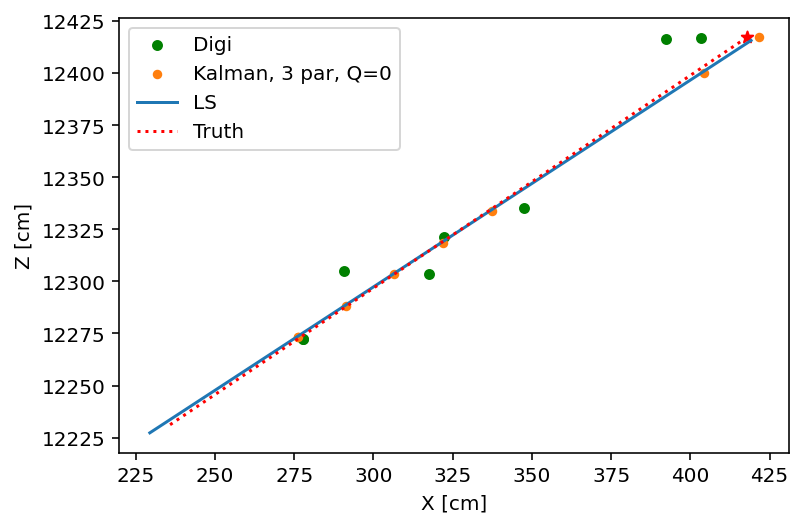

In [160]:
# Turth
dt=hits_truth[1][3]-hits_truth[0][3]
dx=hits_truth[1][0]-hits_truth[0][0]
dy=hits_truth[1][1]-hits_truth[0][1]
dz=hits_truth[1][2]-hits_truth[0][2]
X0_truth = np.array([hits_truth[0][0], hits_truth[0][3], hits_truth[0][2], dx/dt, dy/dt, dz/dt])
# Xlast_truth = np.array([hits_truth[-1][0], hits_truth[-1][3], hits_truth[-1][2], dx/dt, dy/dt, dz/dt])
# print(Xlast_truth)
# print(kf.X_filtered[-1])


# Get one event
ievent=6
hits=Hit_collection[ievent]
truth=Truth_collection[ievent]

# Run fits
# 1. LS
guess=guess_track(hits)
fit1=fit_track(hits,guess)
#print(fit1)
# 2. Kalman, 3 par, Q=0
kf1=fit_kf_1(hits)  
print(X0_truth)
print(kf1.X_smoothed[0])


# Plot digitized and Kalman
for i in range(7):
    scatter(hits[i].x, hits[i].z,color="g",s=20)    
    scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14)
scatter(hits[i].x, hits[i].z,color="g",s=20,label="Digi")    
scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14,label="Kalman, 3 par, Q=0")    


# Plot LS
fit1_res = list(fit1.values)
tlist = np.linspace(0,1000/25,10)
x_plot = fit1_res[0]+fit1_res[4]*tlist
z_plot = fit1_res[2]+fit1_res[6]*tlist
plot(x_plot,z_plot,label="LS")

# Plot Truth
# hits_truth=np.array(hits_truth)
# scatter(hits_truth[:,0],hits_truth[:,2],s=10,color="k",label="Truth")
x_plot = truth[0]+truth[4]*tlist
z_plot = truth[2]+truth[6]*tlist
plot(x_plot,z_plot,label="Truth",color="r",linestyle=":")
scatter(truth[0],truth[2],marker="*",color="r")


xlabel("X [cm]")
ylabel("Z [cm]")
legend()

In [170]:
results={}
# results["hits"]=[]
results["hits_truth"]=[]
results["recon_0"]=[]
results["recon_0_err"]=[]
results["recon_1"]=[]
results["recon_1_err"]=[]

for i in tqdm(range(len(Hit_collection))):
# for i in range(10):
    # Get one event and fit
    hits=Hit_collection[i]
    truth=Truth_collection[i]
    
    
    # 0: LSfit
    guess=guess_track(hits)
    fit1=fit_track(hits,guess)
    # 1: Kalman 3 par, Q=0
    kf1=fit_kf_1(hits)  
    
    
    #print(fit1)
    lsfit_values = [fit1.values[0],fit1.values[3],fit1.values[2],fit1.values[4],fit1.values[5],fit1.values[6]]
    results["recon_0"].append(lsfit_values)
    results["recon_1"].append(kf1.X_smoothed[0])
    results["hits_truth"].append([truth[0],truth[3],truth[2],truth[4],truth[5],truth[6]])

    
    
for key in results:
    results[key] = np.array(results[key])

  0%|          | 0/24000 [00:00<?, ?it/s]/tmp/ipykernel_75128/2618061123.py:56: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser
100%|██████████| 24000/24000 [14:04<00:00, 28.43it/s]


In [172]:
results_fit=results

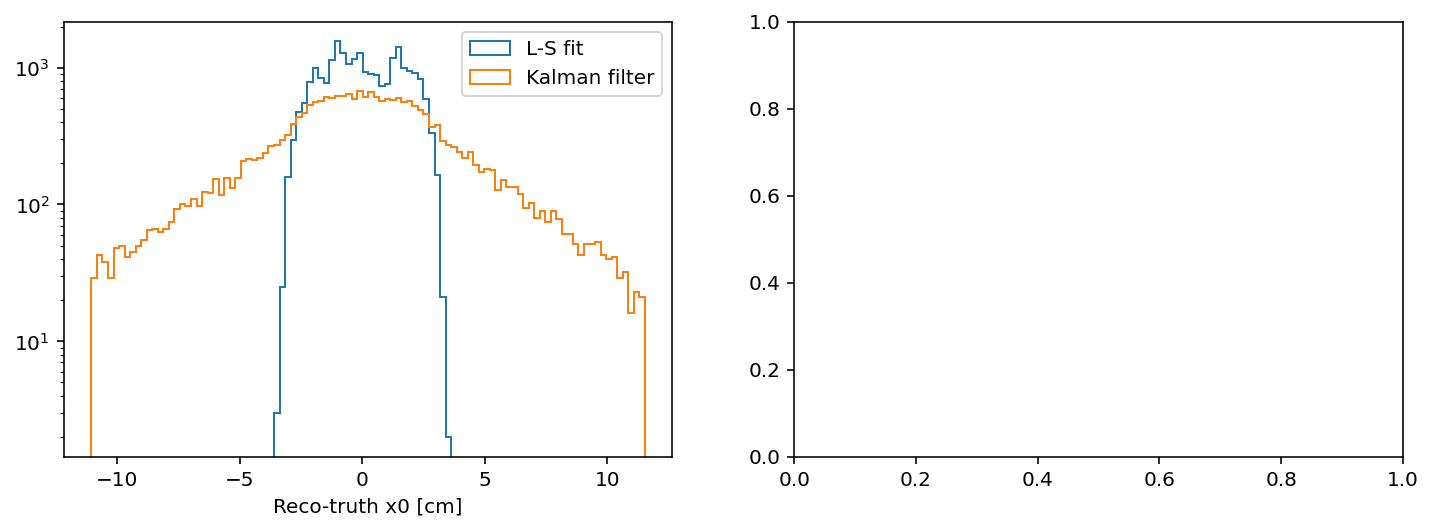

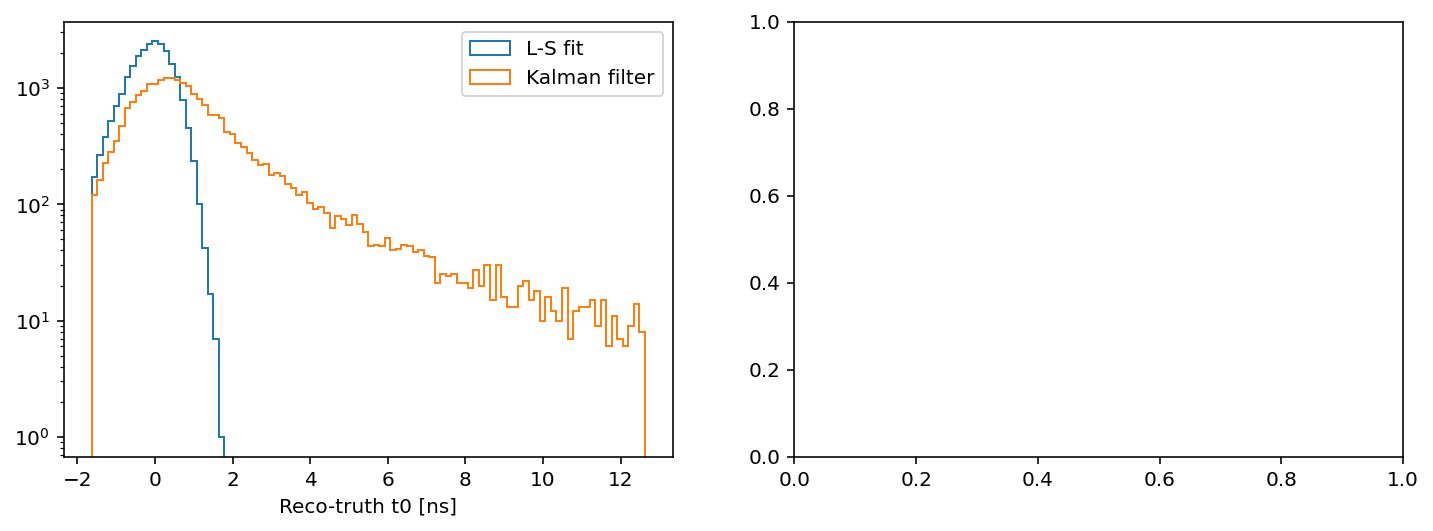

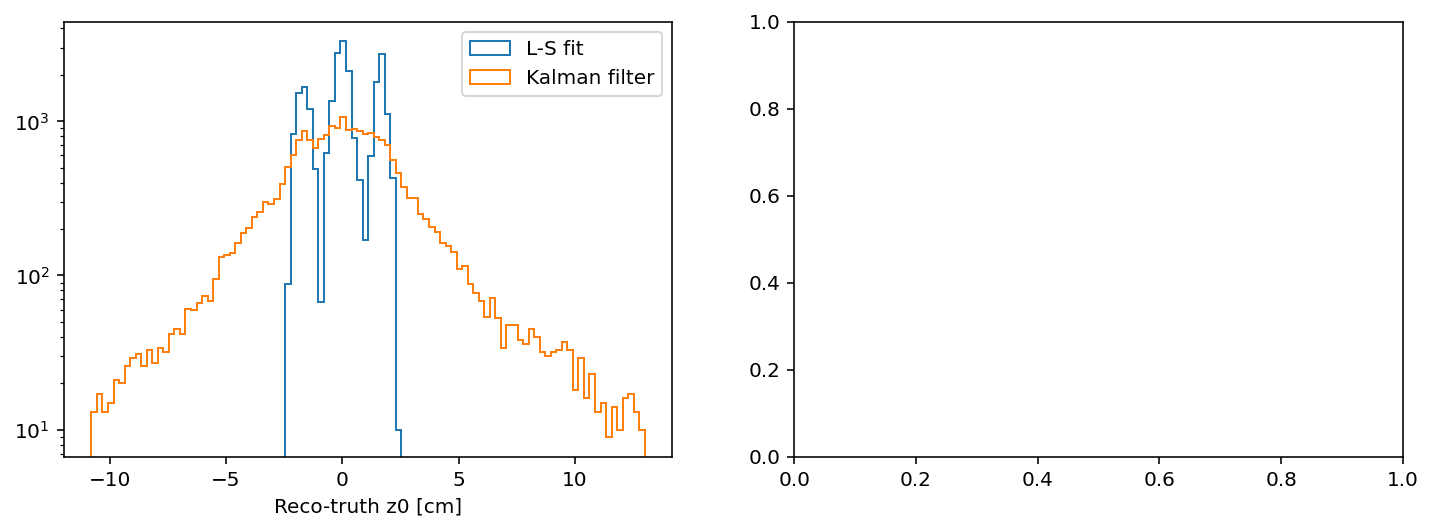

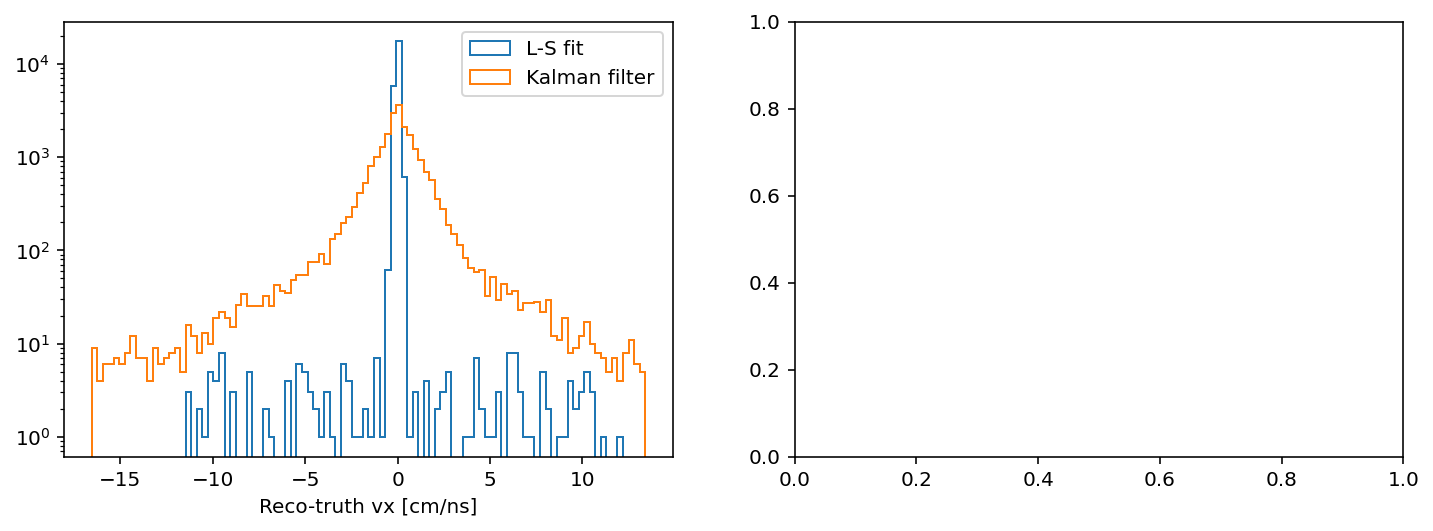

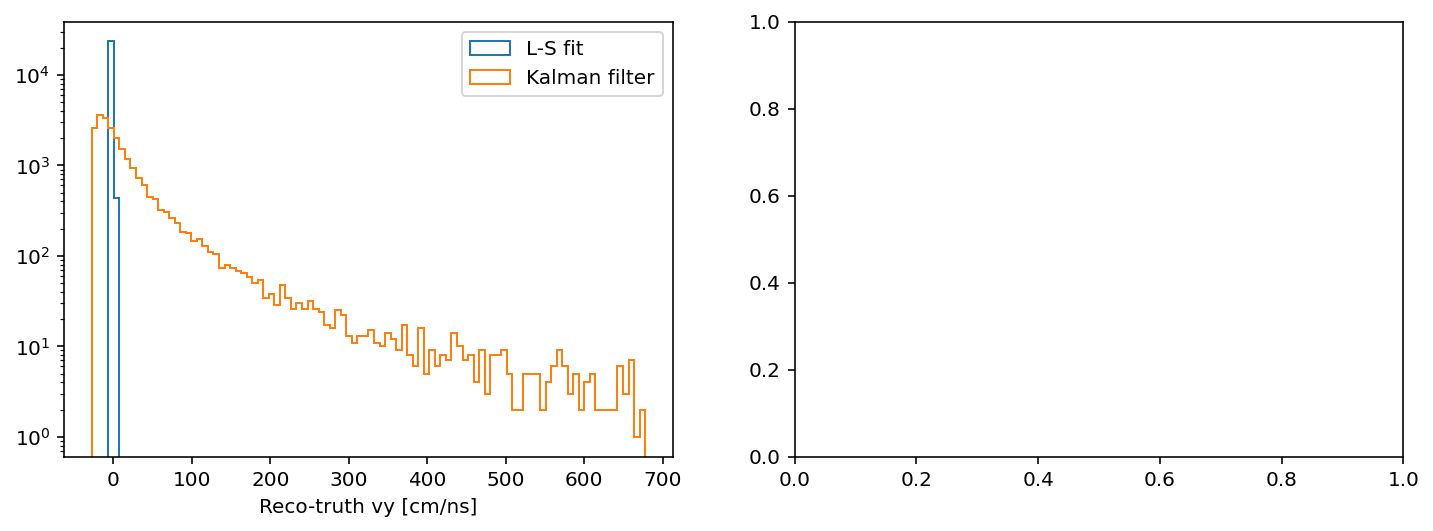

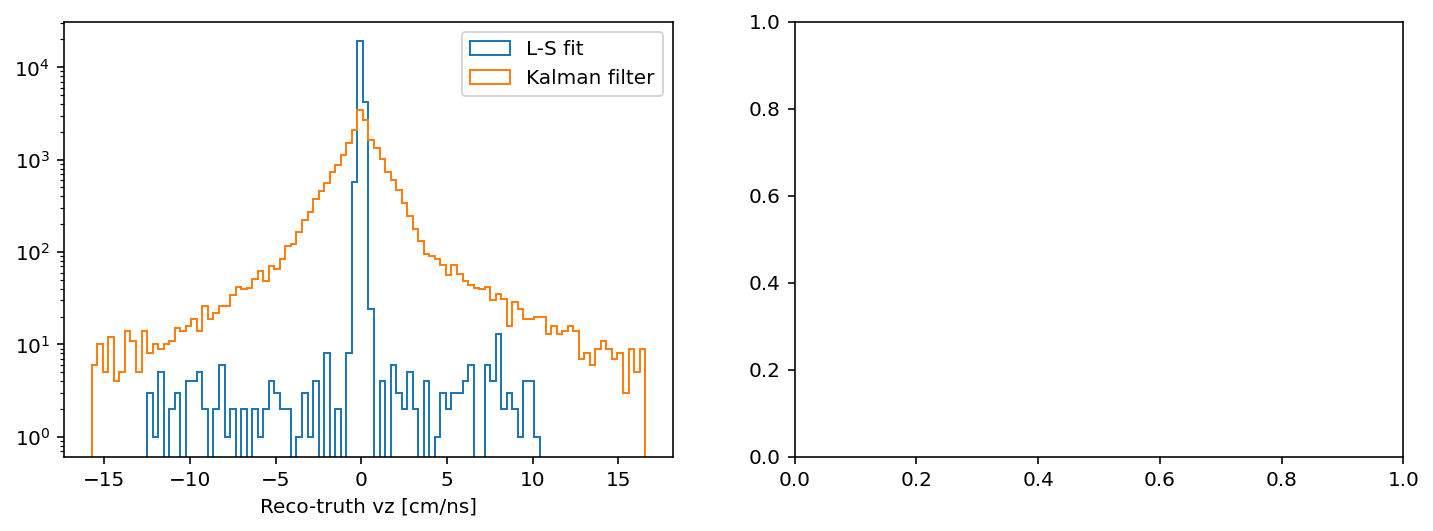

In [175]:
par_names=['x0', 't0','z0',  'vx', 'vy', 'vz'] # Use real world direction
par_unit= ["[cm]",'[ns]',"[cm]","[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

for ipar in range(6):
    #_range=ranges[ipar]
    residual_ls=results_fit["recon_0"][:,ipar]-results_fit["hits_truth"][:,ipar]
    residual_km=results_fit["recon_1"][:,ipar]-results_fit["hits_truth"][:,ipar]
    _range=(np.percentile(residual_km,1),np.percentile(residual_km,99))
    
    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
#     pull_ls=pull(residual_ls,0,results_fit["par_fit_error"][:,ipar])
#     pull_km=pull(residual_km,0,results_fit["par_fit_error"][:,ipar])
    
    fig,axs=plt.subplots(1,2,figsize=(12,4))
    plt.sca(axs[0])
    plt.hist(residual_ls,histtype="step",bins=100,range=_range,label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(residual_km,histtype="step",bins=100,range=_range,label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco-truth {par_names[ipar]} {par_unit[ipar]}")
    plt.yscale("log")
#     plt.sca(axs[1])
#     plt.hist(pull_ls,histtype="step",bins=100,range=(-5,5),label="L-S fit");#bins=np.linspace(360,500,100));
#     plt.hist(pull_km,histtype="step",bins=100,range=(-5,5),label="Kalman filter");#bins=np.linspace(360,500,100));
#     plt.legend()
#     plt.xlabel(f"Reco-truth/Reco_unc {par_names[ipar]} [sigma]")
#     plt.yscale("log")    
    
    
    plt.show()

In [ ]:
hist(results["recon_0"][:,0]-results["hits_truth"][:,0],bins=100,histtype="step");
hist(results["recon_1"][:,0]-results["hits_truth"][:,0],bins=100,histtype="step");
yscale("log")